In [1]:
import sys
sys.path.append("../src/")
from data import train_and_testloader_from_pc, dataloader_from_pc
from model import AEDist
import numpy as np
import torch
import phate
from heatgeo.embedding import HeatGeo
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from scipy.spatial import procrustes
import scanpy as sc
import scprep
import matplotlib.pyplot as plt
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import wandb
import hydra
import os
from omegaconf import DictConfig, OmegaConf
import wandb
from hydra import initialize, compose
import pickle

In [2]:
adata = sc.read('../data/eb_hv.h5ad', backed='r')

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [3]:
run_name = 'run-20240108_151447-pss67t91'
# run_name = 'run-20240108_151548-1kikew5b'
cfg = OmegaConf.load(f'../src/wandb/{run_name}/files/config.yaml')


In [5]:
ckpt_path=f'../src/wandb/{run_name}/files/epoch=3-step=53824.ckpt'
if cfg.model.value['activation'] == 'relu':
    activation_fn = torch.nn.ReLU()
elif cfg.model.value['activation'] == 'leaky_relu':
    activation_fn = torch.nn.LeakyReLU()
elif cfg.model.value['activation'] == 'sigmoid':
    activation_fn = torch.nn.Sigmoid()
else:
    raise ValueError('Unknown activation function')

model = AEDist.load_from_checkpoint(
    ckpt_path,
    dim=adata.shape[1],
    emb_dim=adata.obsm["X_phate"].shape[1],
    layer_widths=cfg.model.value['layer_widths'],
    activation_fn=activation_fn,
    log_dist=cfg.model.value['log_dist'],
    lr=cfg.model.value['lr'],
)


In [6]:
X_tensor = torch.from_numpy(adata[:,:].X.toarray()).float()
xhat, z = model(X_tensor)
xhat = xhat.cpu().detach().numpy()
z = z.cpu().detach().numpy()

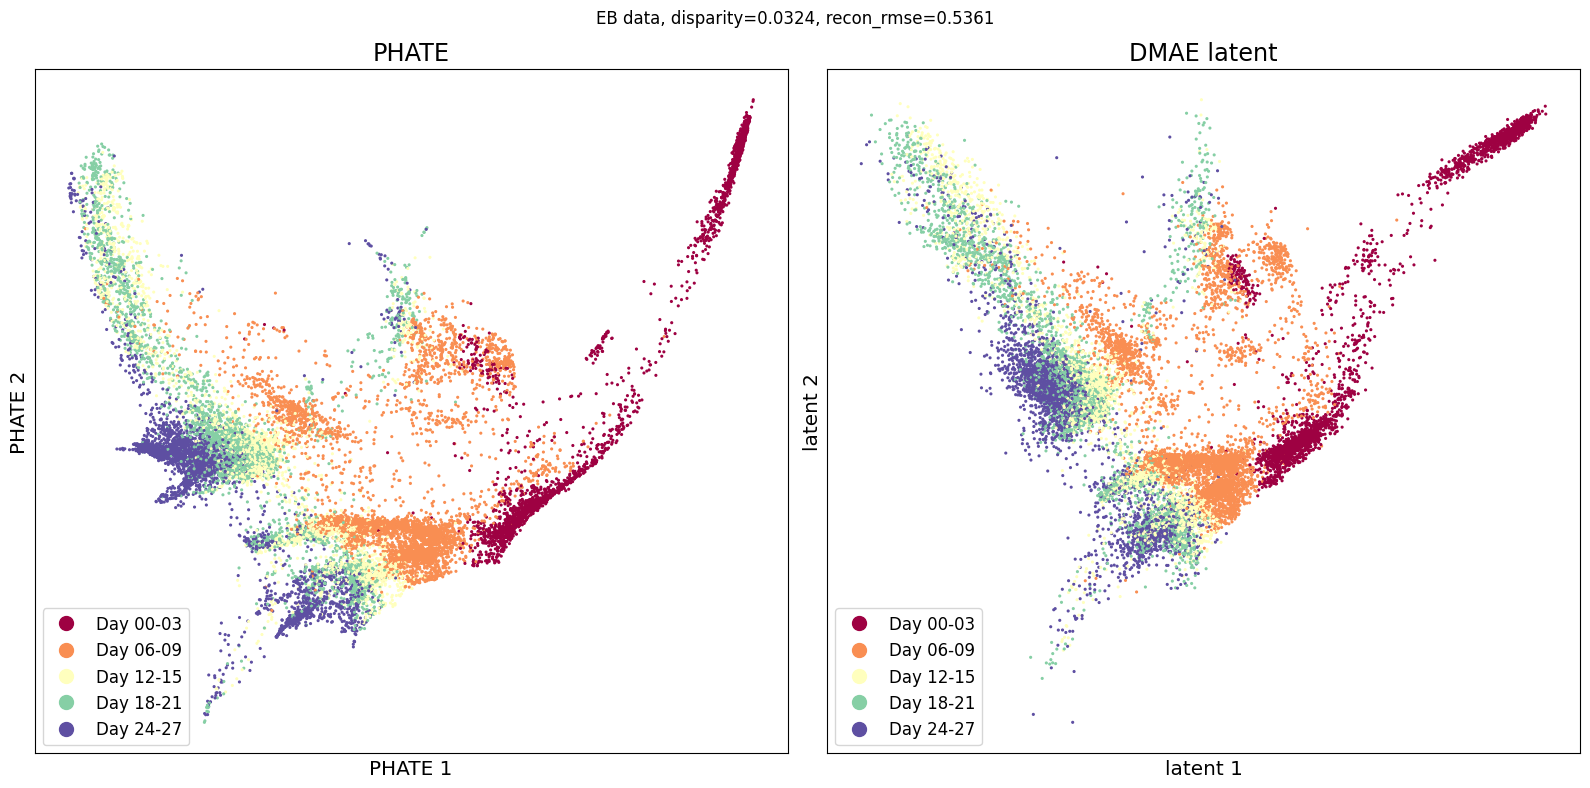

In [7]:
recon_rmse = np.sqrt(np.square(xhat - X_tensor.numpy()).mean())

pc_rot, z_rot, disparity = procrustes(adata.obsm['X_phate'], z)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first scatter plot
scprep.plot.scatter2d(adata.obsm['X_phate'], ax=axes[0], c=adata.obs['sample_labels'], cmap='Spectral',
                      ticks=False, label_prefix="PHATE ", title='PHATE')

# Plot the second scatter plot
scprep.plot.scatter2d(z_rot, ax=axes[1], c=adata.obs['sample_labels'], cmap='Spectral',
                      ticks=False, label_prefix="latent ", title='DMAE latent')
plt.suptitle(f"EB data, disparity={disparity:.4f}, recon_rmse={recon_rmse:.4f}")
plt.tight_layout()
plt.show()

In [8]:
phate_operator_h = phate.PHATE(knn=4, decay=15, t=12, n_jobs=-2)
Y_phate_h = phate_operator_h.fit_transform(xhat)


Calculating PHATE...
  Running PHATE on 16821 observations and 1684 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.69 seconds.
    Calculating KNN search...
    Calculated KNN search in 8.62 seconds.
    Calculating affinities...
    Calculated affinities in 0.09 seconds.
  Calculated graph and diffusion operator in 11.42 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.68 seconds.
    Calculating KMeans...
    Calculated KMeans in 10.77 seconds.
  Calculated landmark operator in 14.34 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.59 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 6.31 seconds.
Calculated PHATE in 33.67 seconds.


<Axes: >

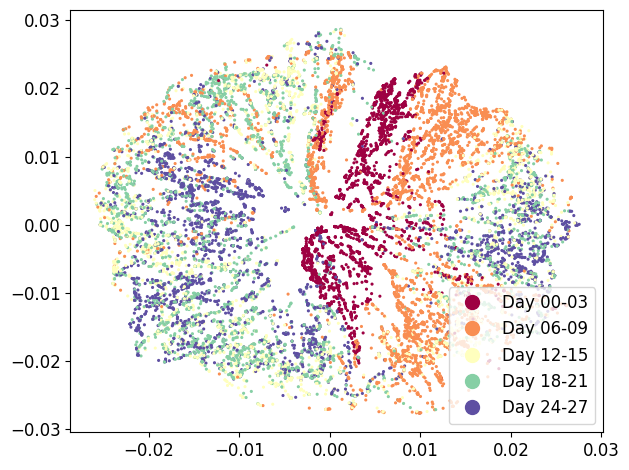

In [9]:
scprep.plot.scatter2d(Y_phate_h, c=adata.obs['sample_labels'], cmap='Spectral',)

In [10]:
pca_loadings = phate_operator_h.graph.data_nu
pca_components = phate_operator_h.graph.data_pca.components_

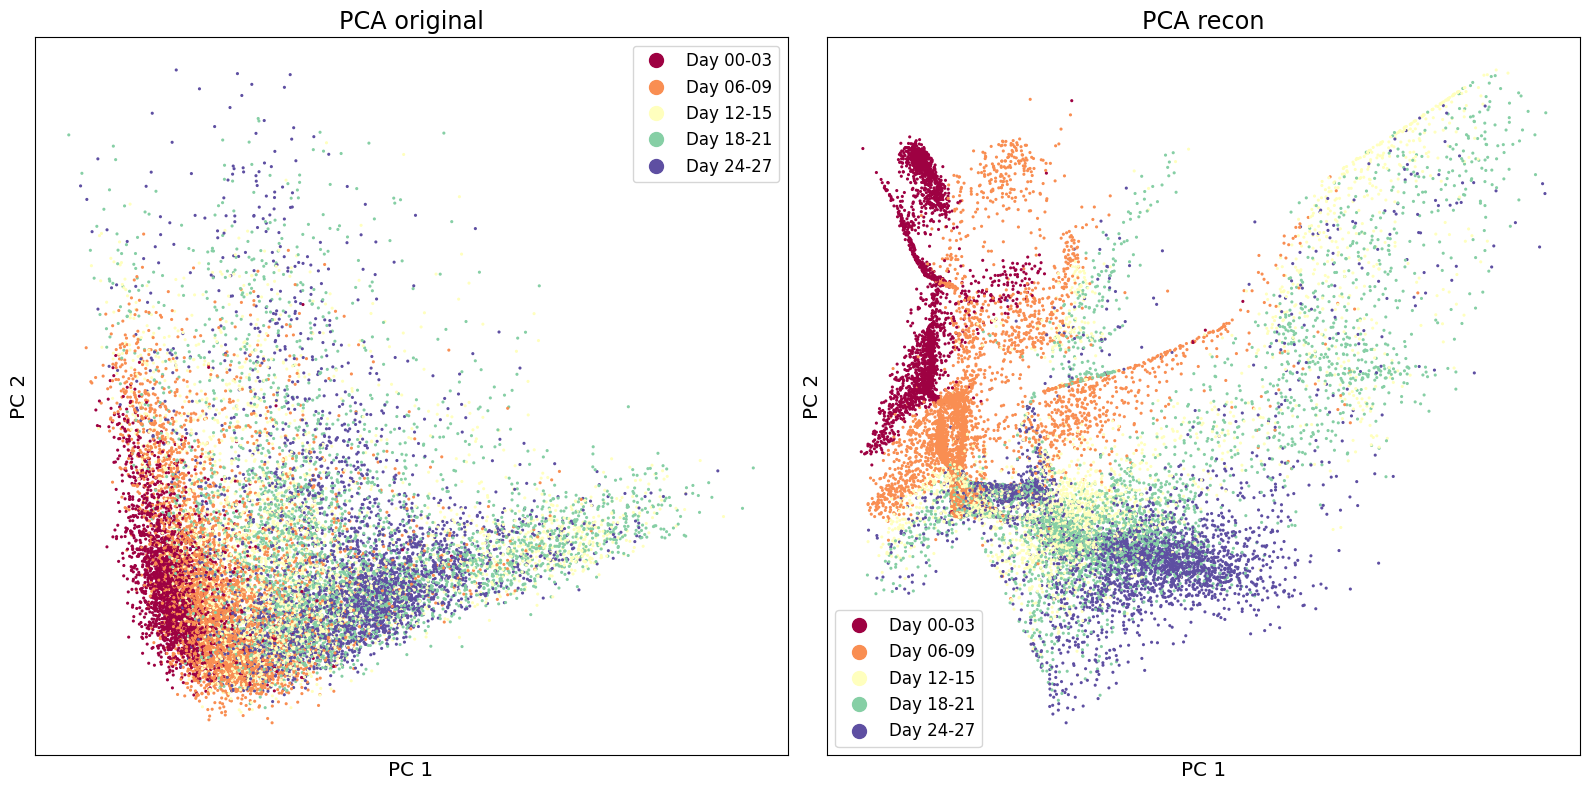

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first scatter plot
scprep.plot.scatter2d(adata.obsm['X_pca'], ax=axes[0], c=adata.obs['sample_labels'], cmap='Spectral',
                      ticks=False, label_prefix="PC ", title='PCA original')

# Plot the second scatter plot
scprep.plot.scatter2d(pca_loadings, ax=axes[1], c=adata.obs['sample_labels'], cmap='Spectral',
                      ticks=False, label_prefix="PC ", title='PCA recon')
plt.tight_layout()
plt.show()

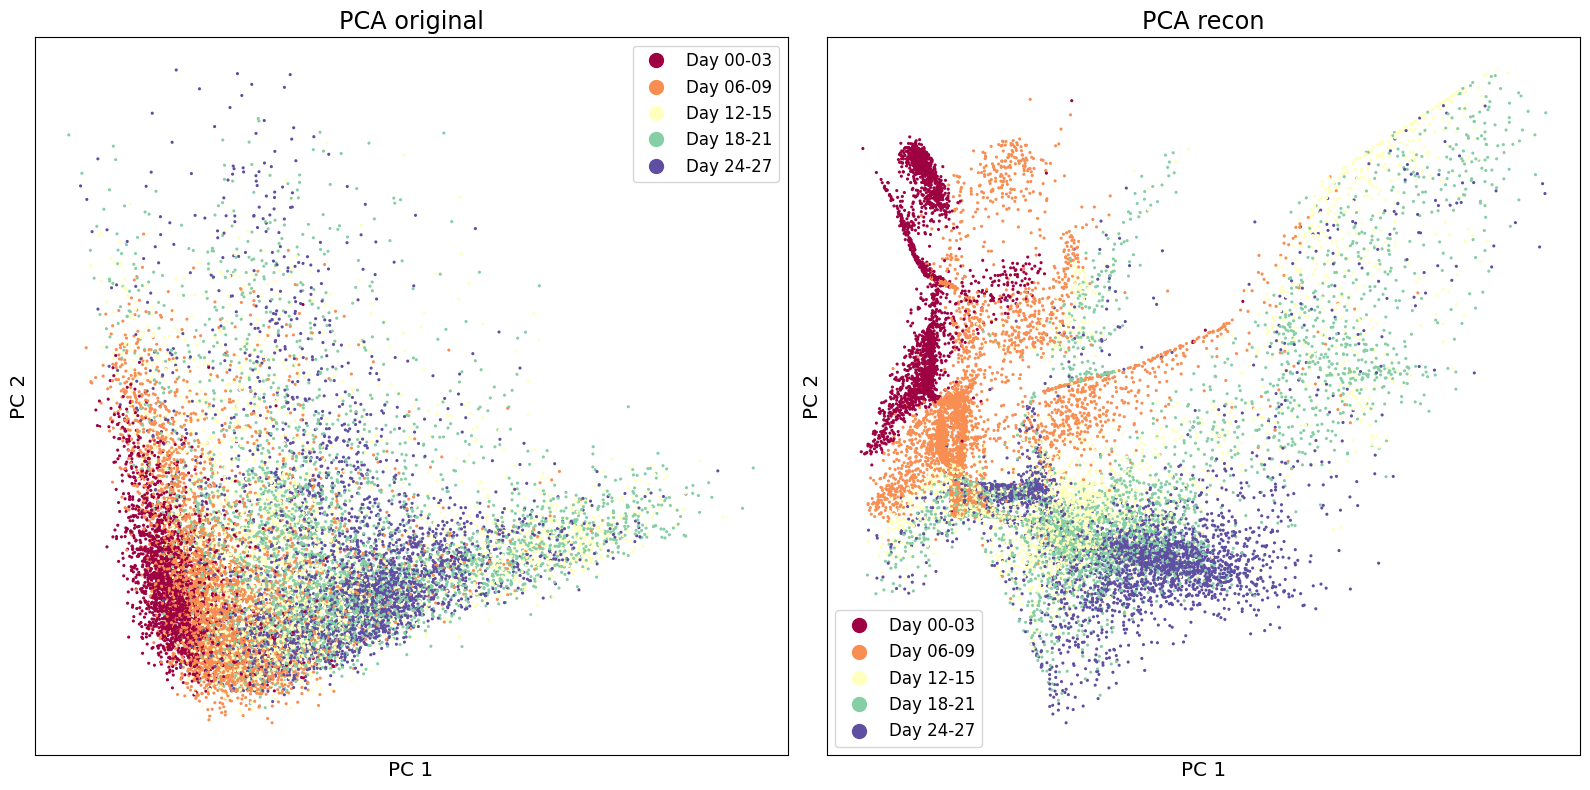

In [17]:
data_pca = adata.obsm['X_pca'][:, :2]
reconstr_pca = pca_loadings[:, :2]
reconstr_pca[:, 1] *= -1
# _, pca_loadings_rot, disparity = procrustes(data_pca, reconstr_pca)
pca_loadings_rot = reconstr_pca

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first scatter plot
scprep.plot.scatter2d(data_pca, ax=axes[0], c=adata.obs['sample_labels'], cmap='Spectral',
                      ticks=False, label_prefix="PC ", title='PCA original')

# Plot the second scatter plot
scprep.plot.scatter2d(pca_loadings_rot, ax=axes[1], c=adata.obs['sample_labels'], cmap='Spectral',
                      ticks=False, label_prefix="PC ", title='PCA recon')
plt.tight_layout()
plt.show()

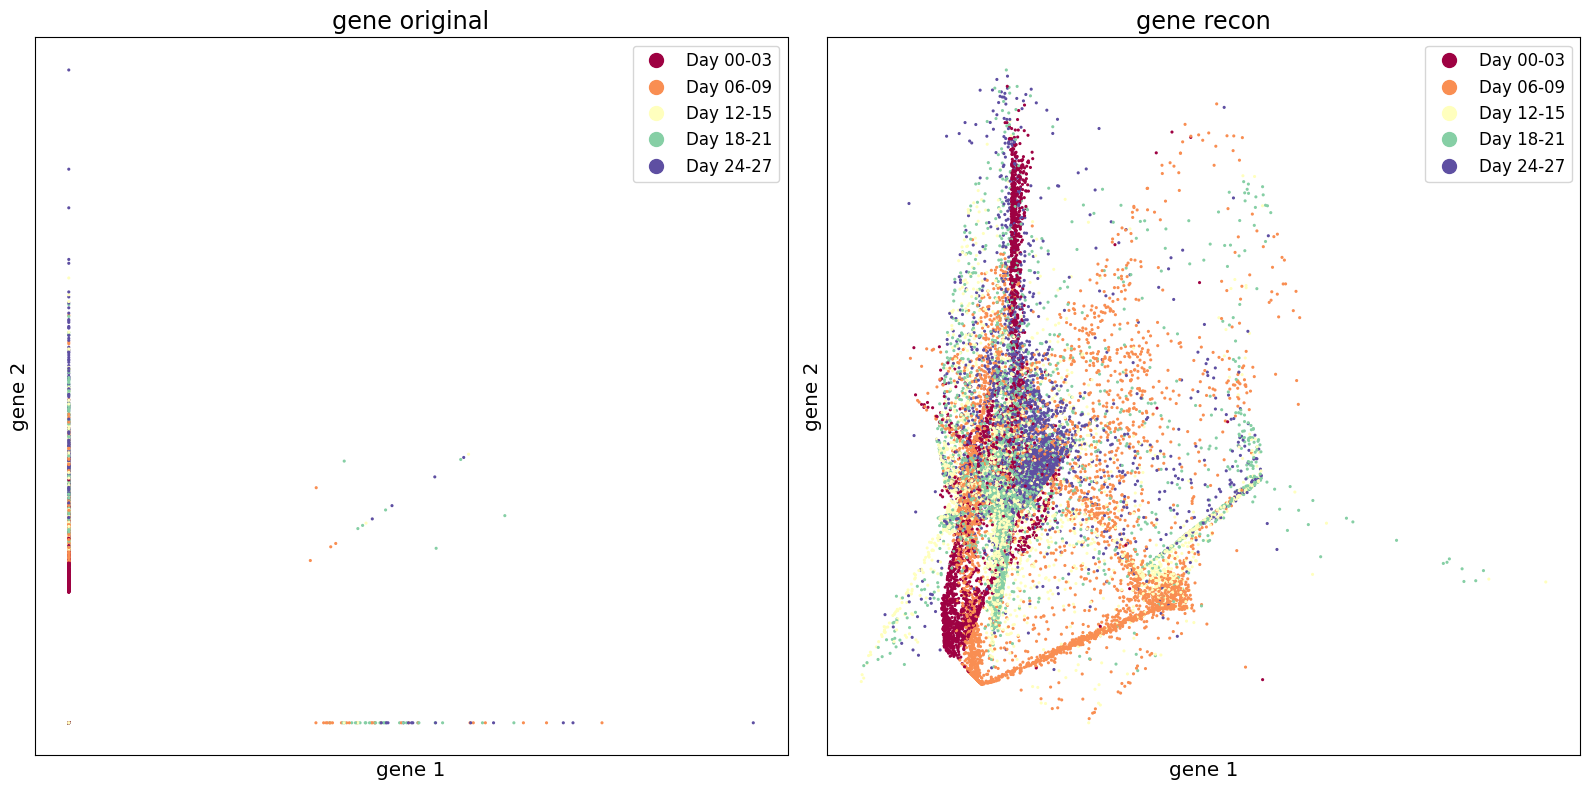

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first scatter plot
scprep.plot.scatter2d(X_tensor.numpy(), ax=axes[0], c=adata.obs['sample_labels'], cmap='Spectral',
                      ticks=False, label_prefix="gene ", title='gene original')

# Plot the second scatter plot
scprep.plot.scatter2d(xhat, ax=axes[1], c=adata.obs['sample_labels'], cmap='Spectral',
                      ticks=False, label_prefix="gene ", title='gene recon')
plt.tight_layout()
plt.show()

In [24]:
import magic

In [25]:
magic_op = magic.MAGIC()
X_magic = magic_op.fit_transform(adata[:,:].X)

Calculating MAGIC...
  Running MAGIC on 16821 cells and 1684 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.61 seconds.
    Calculating KNN search...
    Calculated KNN search in 67.35 seconds.
    Calculating affinities...
    Calculated affinities in 64.55 seconds.
  Calculated graph and diffusion operator in 137.56 seconds.
  Calculating imputation...
  Calculated imputation in 2.21 seconds.
Calculated MAGIC in 139.89 seconds.


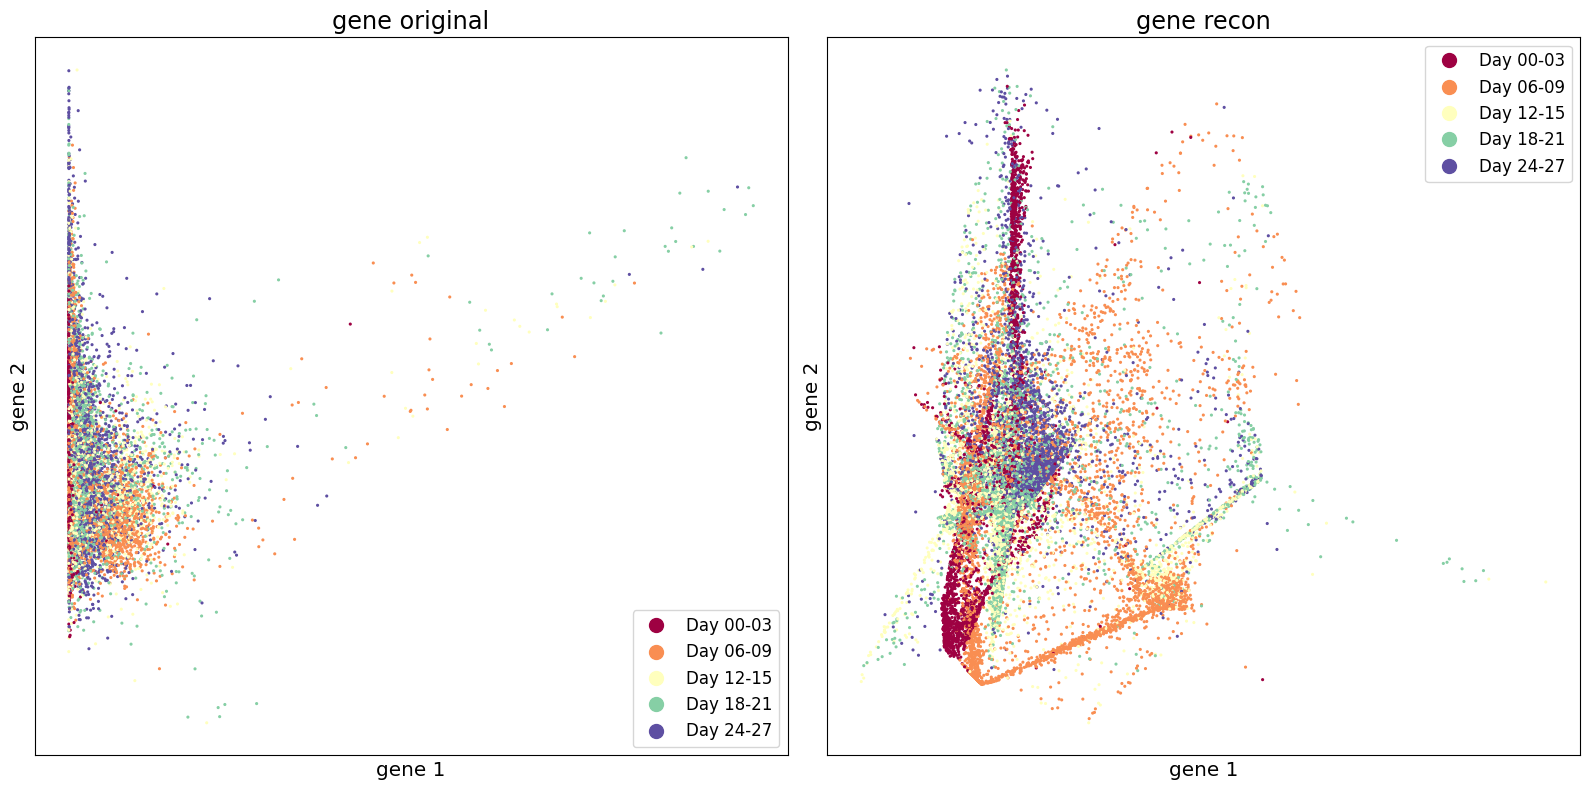

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first scatter plot
scprep.plot.scatter2d(X_magic, ax=axes[0], c=adata.obs['sample_labels'], cmap='Spectral',
                      ticks=False, label_prefix="gene ", title='gene original')

# Plot the second scatter plot
scprep.plot.scatter2d(xhat, ax=axes[1], c=adata.obs['sample_labels'], cmap='Spectral',
                      ticks=False, label_prefix="gene ", title='gene recon')
plt.tight_layout()
plt.show()

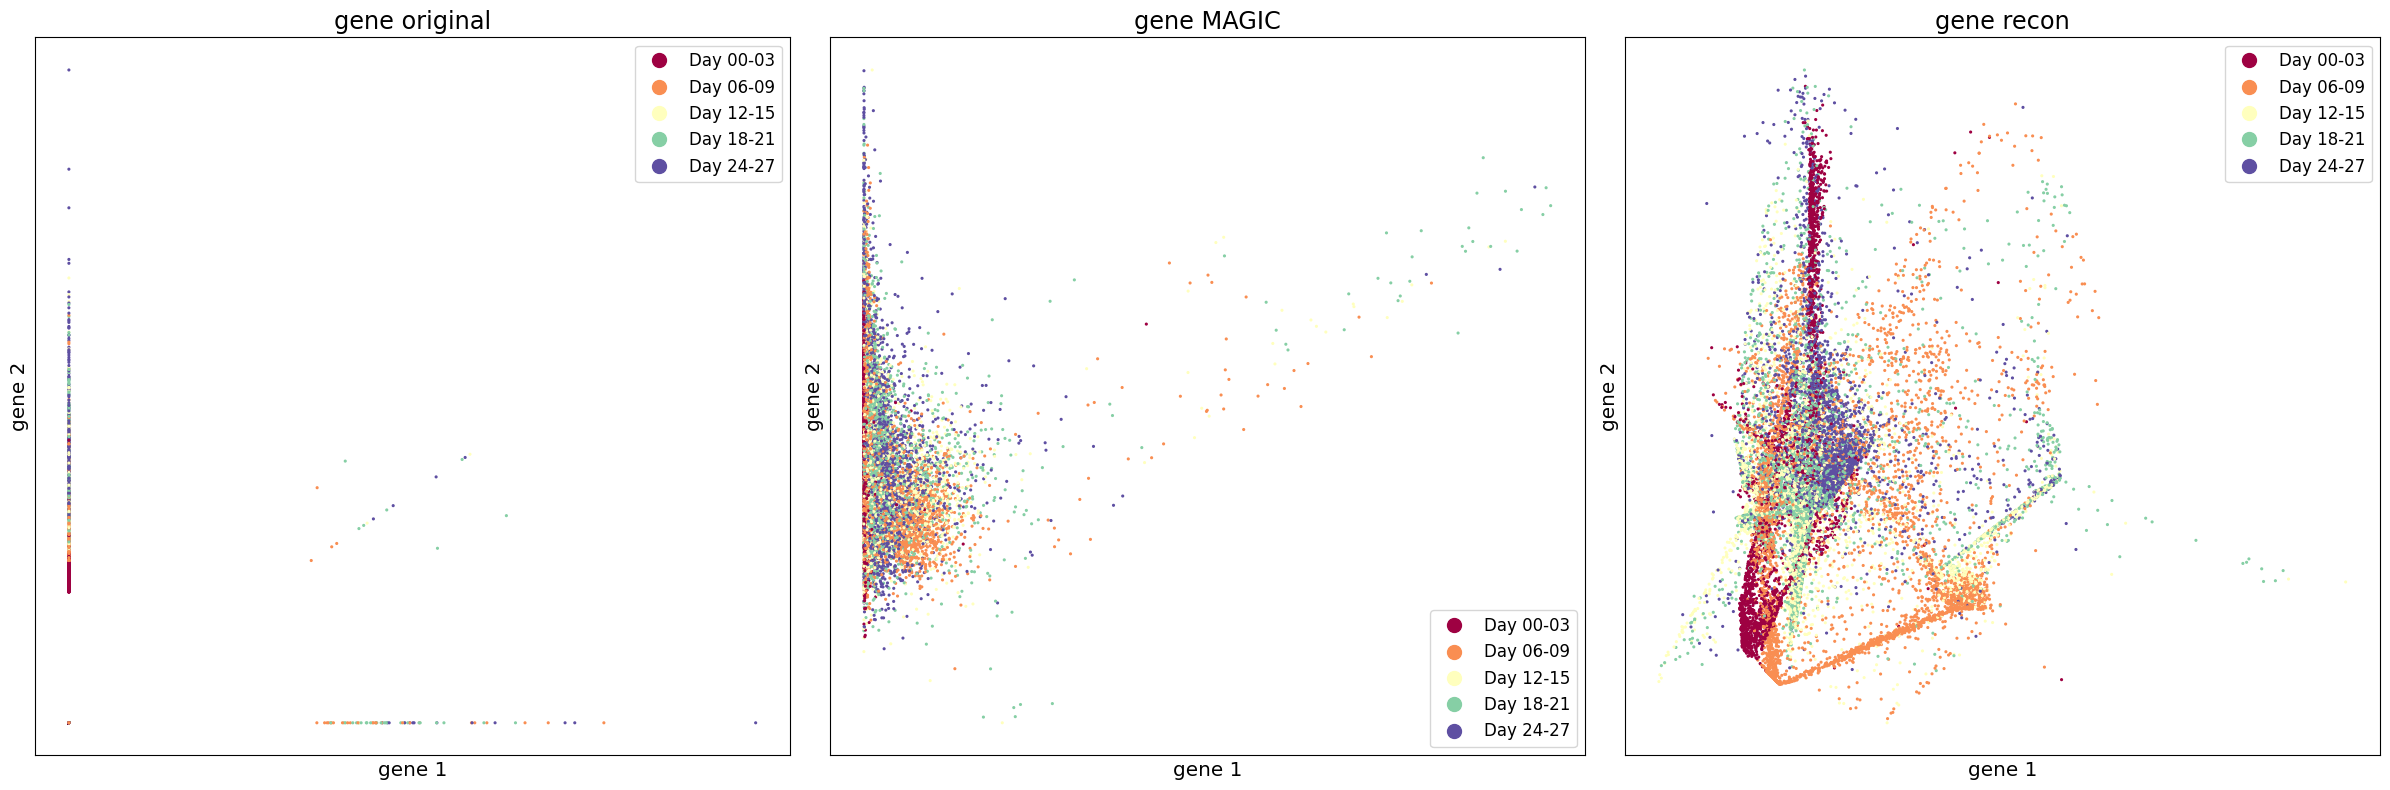

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot the first scatter plot
scprep.plot.scatter2d(X_tensor.numpy(), ax=axes[0], c=adata.obs['sample_labels'], cmap='Spectral',
                      ticks=False, label_prefix="gene ", title='gene original')

# Plot the first scatter plot
scprep.plot.scatter2d(X_magic, ax=axes[1], c=adata.obs['sample_labels'], cmap='Spectral',
                      ticks=False, label_prefix="gene ", title='gene MAGIC')

# Plot the second scatter plot
scprep.plot.scatter2d(xhat, ax=axes[2], c=adata.obs['sample_labels'], cmap='Spectral',
                      ticks=False, label_prefix="gene ", title='gene recon')
plt.tight_layout()
plt.show()

In [37]:
np.square(X_tensor.numpy() - xhat).mean()

0.28742266

In [30]:
np.square(X_magic - xhat).mean()

0.011550714876518575

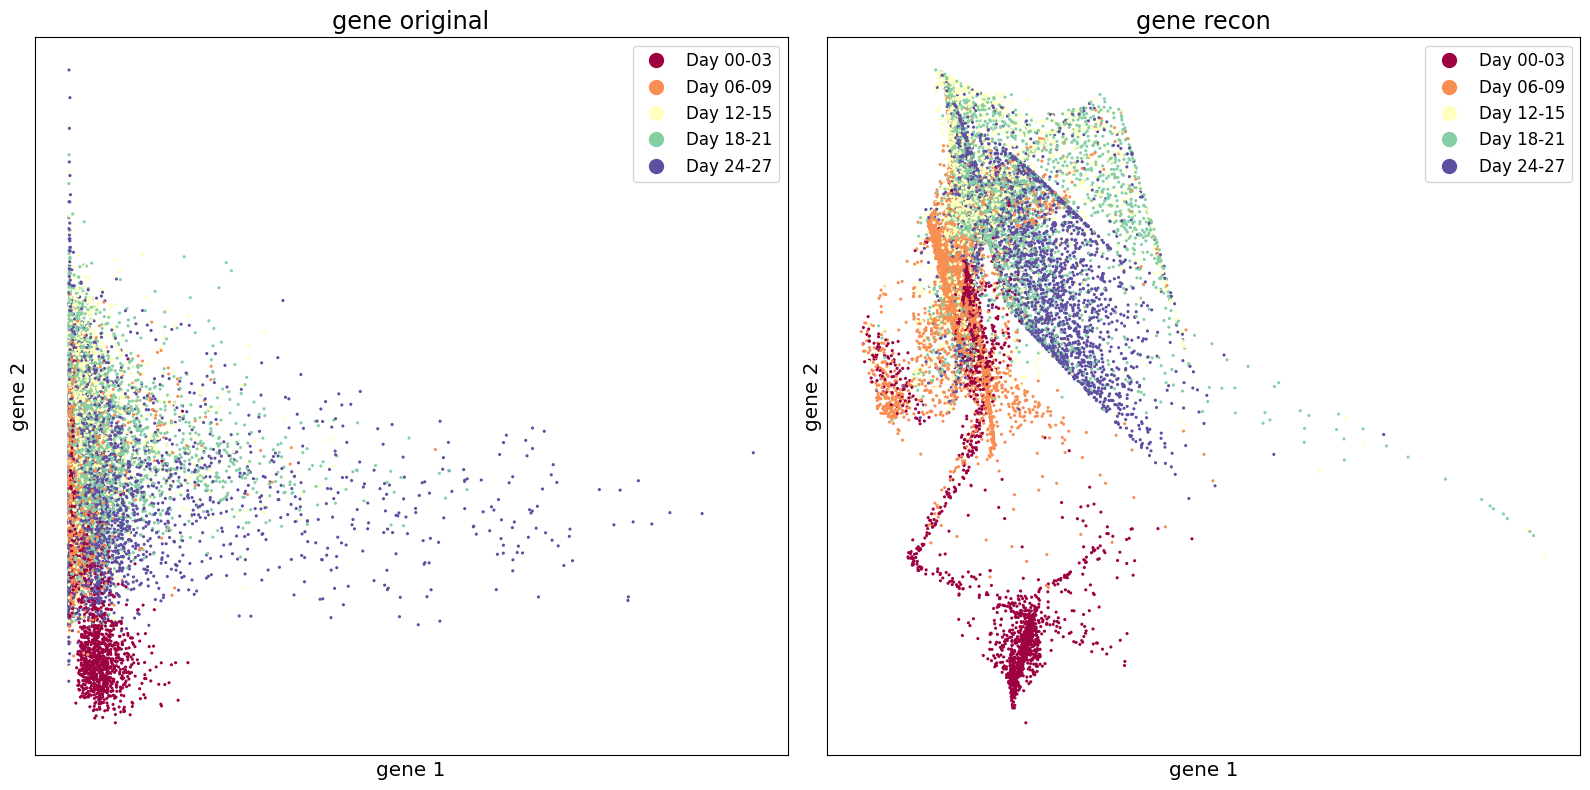

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first scatter plot
scprep.plot.scatter2d(X_magic[:, [12,34]], ax=axes[0], c=adata.obs['sample_labels'], cmap='Spectral',
                      ticks=False, label_prefix="gene ", title='gene original')

# Plot the second scatter plot
scprep.plot.scatter2d(xhat[:, [12,34]], ax=axes[1], c=adata.obs['sample_labels'], cmap='Spectral',
                      ticks=False, label_prefix="gene ", title='gene recon')
plt.tight_layout()
plt.show()

In [34]:
np.square(X_magic).mean()

0.1604735794325327

In [31]:
np.square(X_tensor.numpy() - xhat).mean()

0.28742266

In [33]:
np.var(X_tensor.numpy())

0.39787325

In [ ]:
assert False

In [ ]:
X_tensor = torch.from_numpy(adata[:,:].X.toarray()).float()
xhat, z = model(X_tensor)

In [ ]:
torch.nn.functional.pdist(z)

tensor([0.0418, 0.0387, 0.0029,  ..., 0.0058, 0.0028, 0.0061],
       grad_fn=<PdistBackward0>)

In [ ]:
torch.nn.functional.pdist(X_tensor)

KeyboardInterrupt: 

In [ ]:
pca_loadings_tensor = torch.from_numpy(pca_loadings)

In [ ]:
torch.nn.functional.pdist(pca_loadings_tensor)

tensor([10.4713, 10.3777,  3.9403,  ...,  4.3354,  3.8835,  6.2201])

In [ ]:
phate_op_pca = phate.PHATE(knn=4, decay=15, t=12, n_jobs=-2)
Y_phate_pc = phate_op_pca.fit_transform(adata.obsm['X_pca'])

Calculating PHATE...
  Running PHATE on 16821 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 23.72 seconds.
    Calculating affinities...
    Calculated affinities in 21.20 seconds.
  Calculated graph and diffusion operator in 45.09 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 4.18 seconds.
    Calculating KMeans...
    Calculated KMeans in 7.93 seconds.
  Calculated landmark operator in 13.80 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.64 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.48 seconds.
Calculated PHATE in 66.04 seconds.


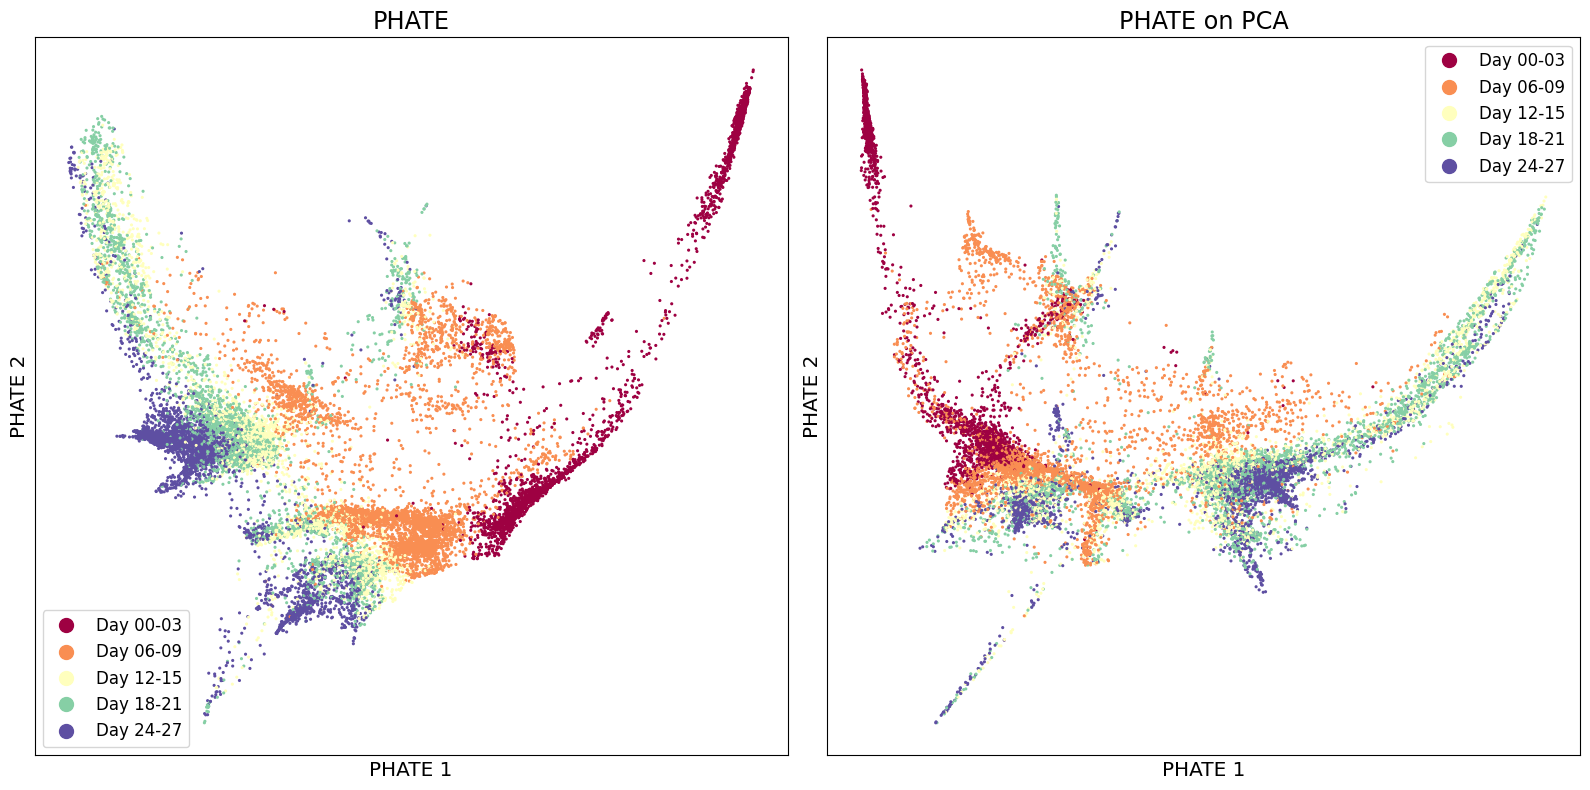

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first scatter plot
scprep.plot.scatter2d(adata.obsm['X_phate'], ax=axes[0], c=adata.obs['sample_labels'], cmap='Spectral',
                      ticks=False, label_prefix="PHATE ", title='PHATE')

# Plot the second scatter plot
scprep.plot.scatter2d(Y_phate_pc, ax=axes[1], c=adata.obs['sample_labels'], cmap='Spectral',
                      ticks=False, label_prefix="PHATE ", title='PHATE on PCA')
plt.tight_layout()
plt.show()